# Fashion MNIST deep learning experiments

### Notebook showing a from scratch implementation of a single layer neural network applied to the Fashion MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#### 1. Importing and preprocessing the Fashion MNIST data

In [2]:
def one_hot_encode(y):
    """
    One-hot encodes input vector y

    Parameters
    ----------
    y : np.array
        Vector to be one-hot encoded

    Returns
    -------
    y_enc : np.array
        One-hot encoding of vector y

    """
    N = y.shape[0]
    y.reshape(N,1)
    values_to_encode = np.unique(y)
    size = len(values_to_encode) # number of values to be encoded
    
    y_enc = np.zeros((N, size))
    for i in range(N):
        y_enc[i, int(y[i])] = 1
    
    return y_enc

In [3]:
def load_and_preprocess():
    """
    Loads training and test data from csv files and stores them in appropriate
    numpy arrays

    Parameters
    ----------
    train_file_path : string
        Name of file within current directory containing training data
    test_file_path : string
        Name of file within current directory containing test data

    Returns
    -------
    images_train : np.array
        Training data images in array of size (N_train, n_px * n_px) where
        N_train is number of training examples and n_px is pixel size of
        images (assuming square images)
    labels_train : np.array
        One-hot encoding of the labels corresponding to training data images.
        Of size (N_train, 10) (10 as this is how many unique values were encoded)
    images_test : np.array
        Training data images in array of size (N_test, n_px * n_px) where
        N_test is number of training examples
    labels_test : np.array
        One-hot encoding of the labels corresponding to test data images.
        Of size (N_test, 10)

    """
    # Load data
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (train_images, train_labels), (val_images, val_labels) = fashion_mnist.load_data()
    
    # Normalize and reshape data
    # Images are currently (N,28,28), we want (784,N)
    N_train = train_images.shape[0]
    N_val = val_images.shape[0]
    nx = train_images.shape[1]
    train_images = train_images.reshape((N_train, nx*nx)).T / 255
    val_images = val_images.reshape((N_val, nx*nx)).T / 255
    
    # One-hot encode the label data (originally of size (N,))
    train_labels_encoded = one_hot_encode(train_labels)
    val_labels_encoded = one_hot_encode(val_labels)
    
    print("Dataset loaded successfully and preprocessed!")
    
    return train_images, train_labels_encoded, val_images, val_labels_encoded, train_labels.reshape((N_train,1)), val_labels.reshape((N_val,1))

In [4]:
images_train, labels_train, images_val, labels_val, labels_train_orig, labels_val_orig = load_and_preprocess()

Dataset loaded successfully and preprocessed!


In [5]:
print("Training images has the shape: " + str(images_train.shape))
print("Training labels has the shape: " + str(labels_train.shape))
print("Training labels (before encoding) has the shape: " + str(labels_train_orig.shape))
print("Validation images has the shape: " + str(images_val.shape))
print("Validation labels has the shape: " + str(labels_val.shape))
print("Number of training examples: " + str(images_train.shape[1]))
print("Number of val examples: " + str(images_val.shape[1]))

print("Original training labels: ")
print(labels_train_orig)
print("Encoded training labels: ")
print(labels_train)

Training images has the shape: (784, 60000)
Training labels has the shape: (60000, 10)
Training labels (before encoding) has the shape: (60000, 1)
Validation images has the shape: (784, 10000)
Validation labels has the shape: (10000, 10)
Number of training examples: 60000
Number of val examples: 10000
Original training labels: 
[[9]
 [0]
 [0]
 ...
 [3]
 [0]
 [5]]
Encoded training labels: 
[[0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


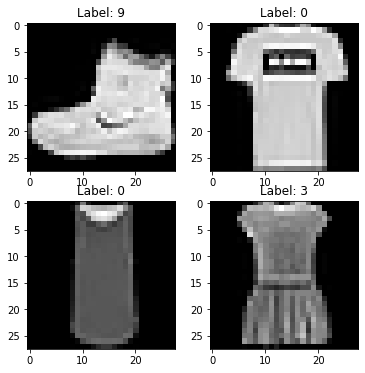

In [6]:
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%labels_train_orig[i])
    plt.imshow(images_train[:,i].reshape([28,28]),cmap='gray');

Define a function to initial the weights and bias of the neurons.

In [20]:
def initialize_parameters(n_in, n_hidden, n_out):
    """
    Initialize w parameter vector and bias with small random values

    Parameters
    ----------
    n_w : int
        number of w paramters to be initialized in w vector
        equal to to the number of input features, n_px*n_px

    Returns
    -------
    w : np.array
        vector of weights initialized with small random values
        of size (n_w, 1)
    b : float
        small randomly initialized bias

    """
    
    w1 = np.random.rand(n_in, n_hidden) * np.sqrt(1/n_hidden)
    b1 = np.zeros((1, n_hidden))
    
    w2 = np.random.rand(n_hidden, n_out) * np.sqrt(1/n_out)
    b2 = np.zeros((1, n_out))
    
    return w1, b1, w2, b2

In [9]:
def sigmoid(x):
    
    s = 1 / (1 + np.exp(-x))
    
    return s

Define a function which will calculate the current prediction based on the current parameters (W and b) and then use gradient descent to improve the parameters.

In [11]:
def update_weights(w1, b1, w2, b2, x, d, labels_orig, n_hidden, alpha):
    """
    Update the values of weights and bias according to
    the value of difference between computed outputs
    and desired ouputs

    Parameters
    ----------
    w : np.array
        vector of weights of size (n_px*n_px, 1)
    b : float
        bias
    x : np.array
        training data of size (n_px*n_px, N)
    d : np.array
        desired outputs for training data of size
        (N, 1)
    N : int
        number of examples

    Returns
    -------
    w_new : np.array
        updated value of weights
    b_new : float
        updated value of bias
    error : float
        total error of dataset

    """
    N = x.shape[1]
    y1 = np.reshape(sigmoid(np.dot(x.T, w1) + b1), (N, n_hidden))
    y2 = np.reshape(sigmoid(np.dot(y1, w2) + b2), (d.shape))
    y_pred = np.reshape(np.argmax(y2, axis = 1), labels_orig.shape)
    diff2 = d - y2
    
    pc_error = float(np.sum(y_pred != labels_orig)) / N * 100
    pc_accuracy = float(np.sum(y_pred == labels_orig)) / N * 100
    
    # Update weights
    dw2 = np.dot(y1.T, diff2)
    db2 = np.sum(diff2, axis = 0, keepdims=True)
    dw1 = np.dot(x, np.dot(diff2, w2.T) *y1*(1-y1))
    db1 = np.sum(np.dot(diff2, w2.T) *y1*(1-y1), axis = 0, keepdims=True)
    
    w1_new = w1 + (alpha * dw1)
    b1_new = b1 + (alpha * db1)
    w2_new = w2 + (alpha * dw2)
    b2_new = b2 + (alpha * db2)
    
    
    return w1_new, b1_new, w2_new, b2_new, pc_error, pc_accuracy

Define the model which will iterate to continually improve the parameters.

In [25]:
def single_hidden_layer_model_train(images_train, labels_train, labels_train_orig, N_hidden = 10, alpha = 0.0001, num_iter = 1000):
    """
    Train a single perceptron model

    Parameters
    ----------
    images_train : np.array
        greyscale (0s and 1s) image matrix 
        of size (N,n_px,n_px)
    labels_train : np.array
        DESCRIPTION.
    alpha : float, optional
        learning rate The default is 0.1.
    acceptable_error : float, optional
        the maximum accpetable percentage error before 
        learning is stopped. The default is 0.

    Returns
    -------
    w : np.array
        final trained values of weights
    b : float
        final trained value of bias
    pc_error : 
        percentage error achieved once training has been completed

    """
    x = images_train
    N = x.shape[1] # number of training examples
    d = labels_train
    w1, b1, w2, b2 = initialize_parameters(x.shape[0], N_hidden, labels_train.shape[1])
    accuracy_log = np.array([])
    
    print("Training has started...")
    
    for i in range(1, num_iter+1):
        w1, b1, w2, b2, pc_error, pc_accuracy = update_weights(w1, b1, w2, b2, x, d, labels_train_orig, N_hidden, alpha)
        accuracy_log = np.append(accuracy_log, pc_accuracy)
        if i % 50 == 0:
            print("Interation " + str(i) + ": % Error on training data = " + str(pc_error))
            print("% accuracy on training data = " + str(pc_accuracy))
    
    print("\n% error on training data: " + str(pc_error))
    print("% accuracy on training data = " + str(pc_accuracy))
    
    return w1, b1, w2, b2, pc_error, pc_accuracy, accuracy_log

Define a function that will generate a prediction on the test set using the trained parameters.

In [26]:
def single_hidden_layer_model_predict(images_val, labels_val, labels_orig, w1, b1, w2, b2):
    """
    Get prediction on test data

    Parameters
    ----------
    images_test : TYPE
        DESCRIPTION.
    labels_test : TYPE
        DESCRIPTION.
    w : TYPE
        DESCRIPTION.
    b : TYPE
        DESCRIPTION.

    Returns
    -------
    y_pred : TYPE
        DESCRIPTION.
    pc_error : TYPE
        DESCRIPTION.

    """
    x = images_val
    N = x.shape[1] # numnber of test examples
    d = labels_val
    N_hidden = w2.shape[0]
    
    # Compute prediction and error
    y1 = np.reshape(sigmoid(np.dot(x.T, w1) + b1), (N, N_hidden))
    y2 = np.reshape(sigmoid(np.dot(y1, w2) + b2), (d.shape))
    y_pred = np.reshape(np.argmax(y2, axis = 1), labels_orig.shape)
    diff2 = d - y2
    pc_error = float(np.sum(y_pred != labels_orig)) / N * 100
    pc_accuracy = float(np.sum(y_pred == labels_orig)) / N * 100
    print("% error on test data: " + str(pc_error))
    print("% accuracy on test data: " + str(pc_accuracy))
    
    return y_pred, pc_error, pc_accuracy

In [27]:
# Main
    
# Train model
# Problem is very sensitive to learning rate
w1, b1, w2, b2, pc_error_train, pc_accuracy_train, train_acc_log = single_hidden_layer_model_train(images_train, labels_train, labels_train_orig, alpha = 0.0001)
# Get predictions on test data
y_pred, pc_error_val, pc_accuracy_val = single_hidden_layer_model_predict(images_val, labels_val, labels_val_orig, w1, b1, w2, b2)

Training has started...
Interation 50: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 100: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 150: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 200: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 250: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 300: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 350: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 400: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 450: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 500: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 550: % Error on training data = 90.0
% accuracy on training data = 10.0
Interation 600: % Error on training data = 90.0
% accuracy on tr

In [28]:
print("Labels test: ")
print(labels_val_orig[0:30,0])
print("Predictions: ")
print(y_pred[0:30,0])

Labels test: 
[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3]
Predictions: 
[9 2 1 1 2 1 2 2 5 7 2 7 5 3 2 1 2 2 8 3 2 7 7 7 1 2 2 3 9 3]


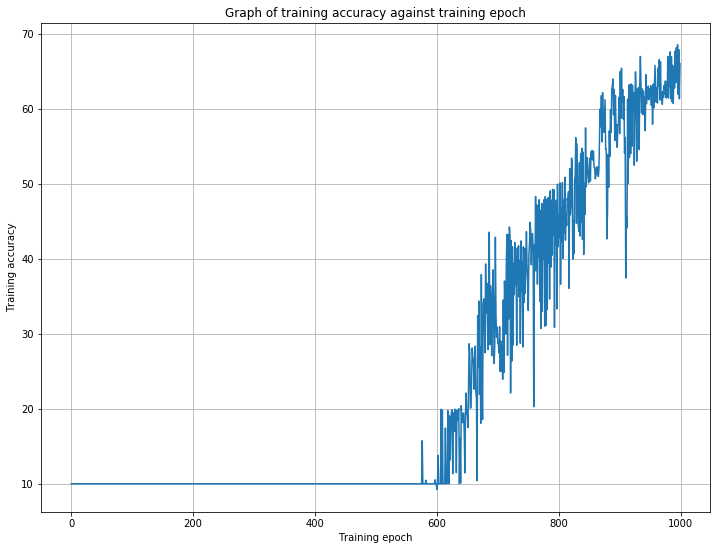

In [29]:
plt.figure(figsize=(12,9))

plt.plot(train_acc_log)

plt.title("Graph of training accuracy against training epoch")
plt.xlabel("Training epoch")
plt.ylabel("Training accuracy")
plt.grid(True)

plt.show()

Work needs to be done to improve this - can experiment with number of hidden layers, learning rate, etc.